In [1]:
import PIL.Image

import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo, MuJoCoParameters
from tqdm import trange
from flygym.util.config import all_leg_dofs
from flygym.state import stretched_pose
from flygym.util.config import all_leg_dofs

In [2]:
plt.rcParams['font.family'] = 'Helvetica Neue'
plt.rcParams['pdf.fonttype'] = 42

In [3]:
# Initialize the simulation
adhesion = True
run_time = 1
sim_params = MuJoCoParameters(timestep=1e-4, render_mode="saved", render_playspeed=0.05)
nmf = NeuroMechFlyMuJoCo(
    sim_params=sim_params,
    init_pose=stretched_pose,
    actuated_joints=all_leg_dofs,
    spawn_pos=(0, 0, 0.2),
)

num_steps_base = int(run_time / nmf.timestep)

In [4]:
# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
with open(data_path / 'behavior' / 'single_steps.pkl', 'rb') as f:
    data = pickle.load(f)

In [7]:
data["swing_stance_time"]

{'swing': {'RF': 0.0098,
  'LF': 0.0098,
  'RM': 0.0012000000000000001,
  'LM': 0.0012000000000000001,
  'RH': 0.0012000000000000001,
  'LH': 0.0012000000000000001},
 'stance': {'RF': 0.0408,
  'LF': 0.0408,
  'RM': 0.0318,
  'LM': 0.0318,
  'RH': 0.027200000000000002,
  'LH': 0.027200000000000002}}

In [9]:
# Interpolate 5x
step_duration = len(data['joint_LFCoxa'])
interp_step_duration = int(step_duration * data['meta']['timestep'] / nmf.timestep)
data_block = np.zeros((len(nmf.actuated_joints), interp_step_duration))
measure_t = np.arange(step_duration) * data['meta']['timestep']
interp_t = np.arange(interp_step_duration) * nmf.timestep
for i, joint in enumerate(nmf.actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

In [10]:
n_stabilization_step = 2000

obs, _ = nmf.reset()

legs = ["RF", "LF", "RM", "LM", "RH", "LH"]
match_joints_to_leg = np.array([[i for i, joint in enumerate(nmf.actuated_joints) if leg in joint] for leg in legs])
obs_list = []

for i, l in enumerate(legs):
    if i == 0:
        for j in range(n_stabilization_step):
            joint_angles = data_block[:, 0]
            action = {"joints": joint_angles, "adhesion":np.zeros(6)}
            obs, _, _, _, _ = nmf.step(action)
            obs_list.append(obs)
            render_status = nmf.render()
        
    for j in range(interp_step_duration):
        joint_angles = data_block[:, 0]
        joint_angles[match_joints_to_leg[i]] = data_block[match_joints_to_leg[i], j]
        action = {"joints": joint_angles, "adhesion":np.zeros(6)}
        obs, _, _, _, _ = nmf.step(action)
        obs_list.append(obs)
        render_status = nmf.render()

In [11]:
video_path = Path(f"outputs/single_step.mp4")
nmf.save_video(video_path)

from ipywidgets import Video
Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

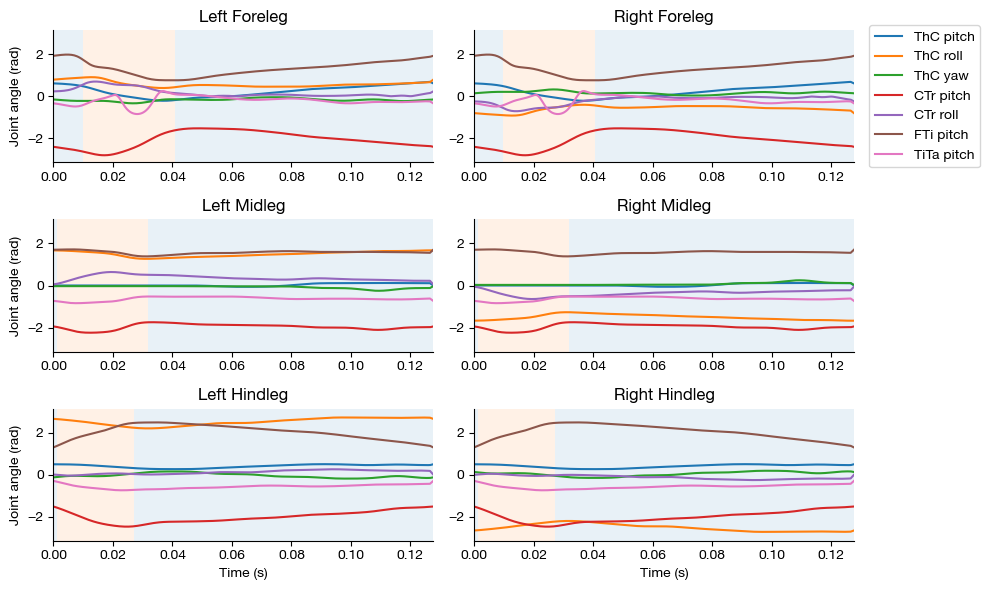

In [17]:
side_lookup = {"L": "left", "R": "right"}
pos_lookup = {"F": "fore", "M": "mid", "H": "hind"}
joint_lookup = {
    "Coxa": "ThC pitch",
    "Coxa_roll": "ThC roll",
    "Coxa_yaw": "ThC yaw",
    "Femur": "CTr pitch",
    "Femur_roll": "CTr roll",
    "Tibia": "FTi pitch",
    "Tarsus1": "TiTa pitch",
}

fig, axs = plt.subplots(3, 2, figsize=(10, 6), tight_layout=True)
for i, (pos_code, pos) in enumerate(pos_lookup.items()):
    for j, (side_code, side) in enumerate(side_lookup.items()):
        ax = axs[i, j]
        for joint_code, joint_name in joint_lookup.items():
            idx = all_leg_dofs.index(f"joint_{side_code}{pos_code}{joint_code}")
            ax.plot(interp_t, data_block[idx, :], label=joint_name)

        # plot adhesion on/off
        swing_start = data["swing_stance_time"]["swing"][f"{side_code}{pos_code}"]
        stance_start = data["swing_stance_time"]["stance"][f"{side_code}{pos_code}"]
        ax.fill_between(
            [0, swing_start],
            [-np.pi, -np.pi],
            [np.pi, np.pi],
            facecolor="tab:blue",
            edgecolor="none",
            alpha=0.1,
        )
        ax.fill_between(
            [swing_start, stance_start],
            [-np.pi, -np.pi],
            [np.pi, np.pi],
            facecolor="tab:orange",
            edgecolor="none",
            alpha=0.1,
        )
        ax.fill_between(
            [stance_start, interp_t[-1]],
            [-np.pi, -np.pi],
            [np.pi, np.pi],
            facecolor="tab:blue",
            edgecolor="none",
            alpha=0.1,
        )

        ax.set_title(f"{side} {pos}leg".title())
        ax.set_ylim(-np.pi, np.pi)
        ax.set_xlim(0, interp_t[-1])
        if i == 0 and j == 1:
            ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
        if i == 2:
            ax.set_xlabel("Time (s)")
        if j == 0:
            ax.set_ylabel("Joint angle (rad)")
sns.despine()
fig.savefig("outputs/single_step.pdf", bbox_inches="tight")